# HW 10 CLUSTERING BUSINESS
cluster time trends in NYC businesses: 

## DATA: Census Business data:

## Download census data for businesses by ZIP code. The data is here http://www.census.gov/econ/cbp/download/

## and it can be downloaded by hand. you can also download it with 3 terminal commands as follows: the data from 1993 through 2001 is different in the format of its path than the data after 2001 (that is why more than one for loop is needed)



# NYC zip codes shape file is here
## http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981


NOTES: 
to read in a zip file without unzipping it you can use the pandas and zipfile packages

# 1. Collecting data

In [ ]:
%%bash
cd data 

for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

for ((y=0; y<=1; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0$y\totals.zip; done

for ((y=2; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done


### Get the zip file list of nyc department

In [1]:
import json
import urllib2
import numpy as np
import pandas as pd
url = "https://nycdatastables.s3.amazonaws.com/2013-08-19T18:18:28.877Z/nyc-zip-code-tabulation-areas-polygons.geojson"
request = urllib2.urlopen(url)
nyc = json.load(request)

In [2]:
# store the nyc_zip
nyc_zip = []
for department in nyc['features']:
    nyc_zip.append(str(department['properties']["postalCode"]))

In [10]:
import os
path = os.getcwd()+'/data'
path
os.chdir(path)

In [11]:
import zipfile #i am not giving it a name cause i intend to use it only once
tr0 = range(1994,2014)
tr1 = range(1998,2003)
ffname = "zbp{0}totals.zip"
biz_zip = set()
for i in tr0:
    if i in tr1:
        st = str(i)[2:]
        fname = ffname.format(st)
        zf = zipfile.ZipFile(fname)
        df = pd.read_csv(zf.open(fname.replace('.zip','.txt')),dtype={'ZIP':str})
        df.columns=[u'zip', u'name', u'empflag', u'emp', u'qp1', u'ap', u'est']
    else:
        st = str(i)[2:]
        fname = ffname.format(st)
        zf = zipfile.ZipFile(fname)
        df = pd.read_csv(zf.open(fname.replace('.zip','.txt')),dtype={'zip':str})
    new_zip = set(df.zip).intersection(set(nyc_zip))
    biz_zip = biz_zip.union(new_zip)

In [12]:
biz_zip = sorted(biz_zip)

In [18]:
biz_data_est = pd.DataFrame(np.nan,index=biz_zip,columns=tr0)

In [19]:
for i in tr0:
    if i in tr1:
        st = str(i)[2:]
        fname = ffname.format(st)
        zf = zipfile.ZipFile(fname)
        df = pd.read_csv(zf.open(fname.replace('.zip','.txt')),dtype={'ZIP':str})
        df.columns=[u'zip', u'name', u'empflag', u'emp', u'qp1', u'ap', u'est']
    else:
        st = str(i)[2:]
        fname = ffname.format(st)
        zf = zipfile.ZipFile(fname)
        df = pd.read_csv(zf.open(fname.replace('.zip','.txt')),dtype={'zip':str})
    for j in biz_zip:
        if j in list(set(df.zip)):
            biz = df[df.zip==j]
            biz_data_est.loc[j][i]=int(biz.est)

In [395]:
biz_zip = biz_data_est.index

In [30]:
biz_data_est = biz_data_est.dropna()

In [40]:
biz_data_est.to_csv('output.csv',index_label='zip')

In [413]:
kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

# 2. Data processing

In [117]:
mydata = pd.read_csv('output.csv',index_col='zip')

In [118]:
result = mydata.copy()
for i in range(len(mydata)):
    result.iloc[i] = (result.iloc[i]-np.mean(result.iloc[i]))/np.std(result.iloc[i])

# 3. KMeans Clustering

In [132]:
import matplotlib.pyplot as plt
%matplotlib inline

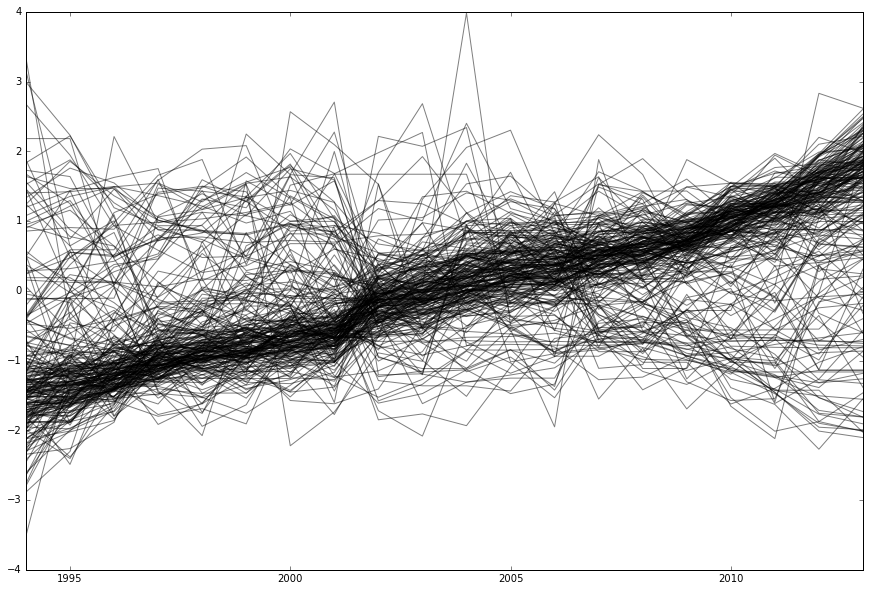

In [292]:
plt.figure(figsize=(15,10))
plt.xlim(1994,2013)
for i in range(len(result)):
    plt.plot(result.iloc[i],'k',alpha=0.5)

In [212]:
def euclid_dist(t1,t2):
    return np.sqrt(sum((t1-t2)**2))

In [424]:
def k_means_clust(data,num_clust,num_iter):
    centroids=random.sample(data,num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        print counter
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if euclid_dist(i,j)<min_dist:
                    min_dist = euclid_dist(i,j)
                    closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]
    
        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
    return centroids

In [425]:
x = result.values

1
2
3
4
5
6
7
8
9
10


<function matplotlib.pyplot.show>

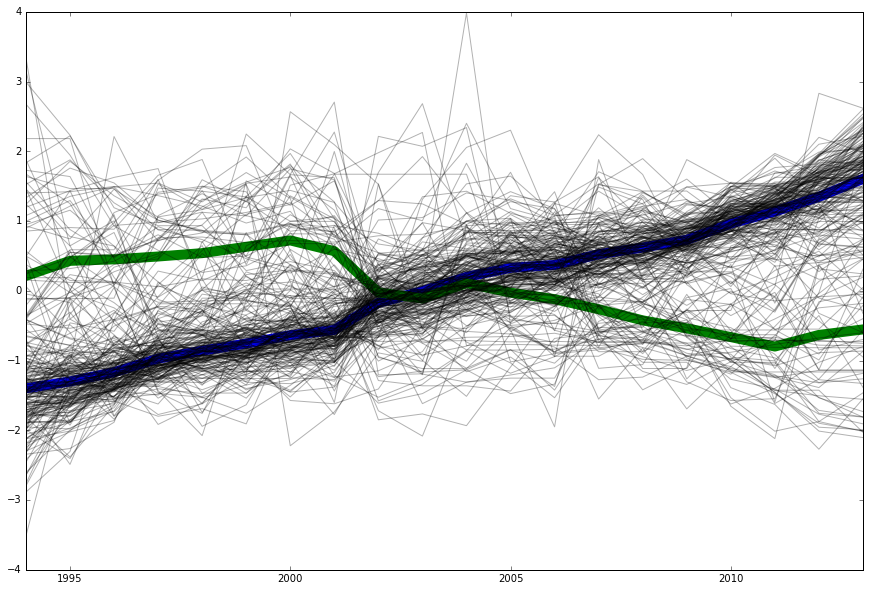

In [429]:
centroids=k_means_clust(x,2,10)
plt.figure(figsize=(15,10))
plt.xlim(1994,2013)
for i in range(len(centroids)):
    plt.plot(tr0,centroids[i],linewidth=10) 
for i in range(len(result)):
    plt.plot(result.iloc[i],'k',alpha=0.3)

plt.show

1
2
3
4
5
6
7
8
9
10


<function matplotlib.pyplot.show>

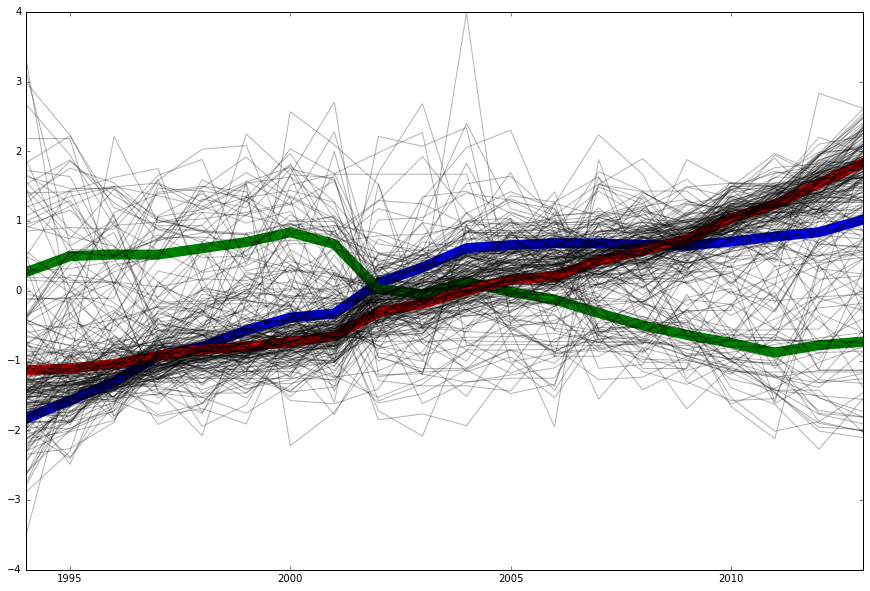

In [426]:
centroids=k_means_clust(x,3,10)
plt.figure(figsize=(15,10))
plt.xlim(1994,2013)
for i in range(len(centroids)):
    plt.plot(tr0,centroids[i],linewidth=10) 
for i in range(len(result)):
    plt.plot(result.iloc[i],'k',alpha=0.3)

plt.show

1
2
3
4
5
6
7
8
9
10


<function matplotlib.pyplot.show>

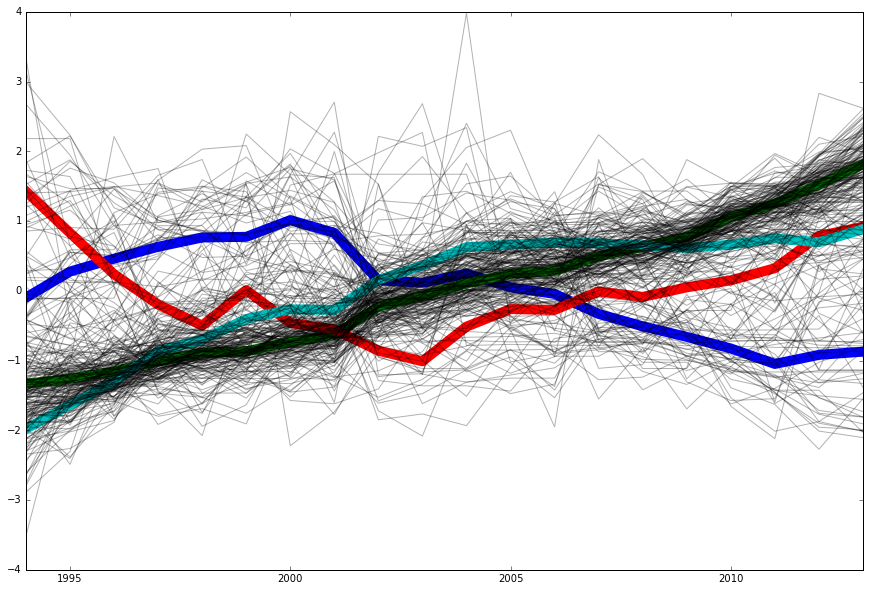

In [427]:
centroids=k_means_clust(x,4,10)
plt.figure(figsize=(15,10))
plt.xlim(1994,2013)
for i in range(len(centroids)):
    plt.plot(tr0,centroids[i],linewidth=10) 
for i in range(len(result)):
    plt.plot(result.iloc[i],'k',alpha=0.3)

plt.show

1
2
3
4
5
6
7
8
9
10


<function matplotlib.pyplot.show>

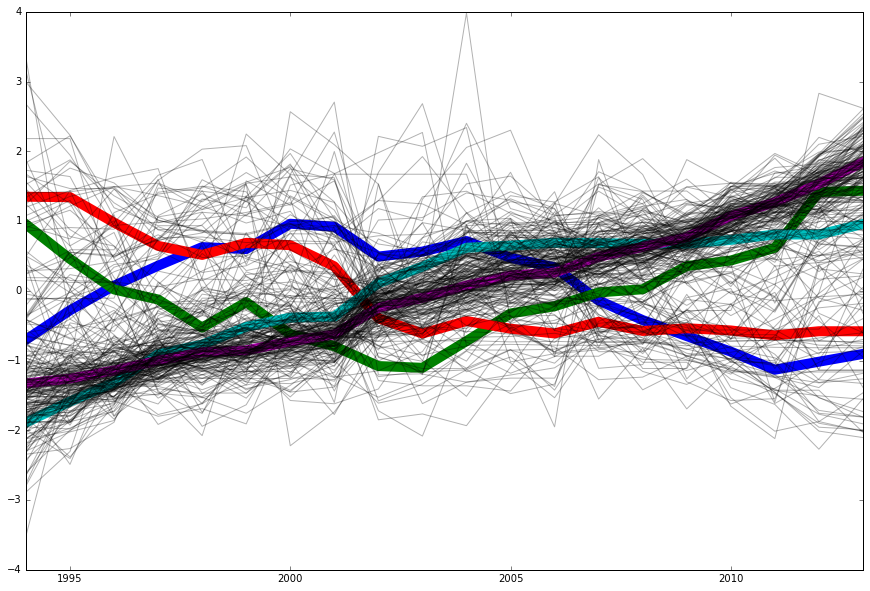

In [431]:
centroids=k_means_clust(x,5,10)
plt.figure(figsize=(15,10))
plt.xlim(1994,2013)
for i in range(len(centroids)):
    plt.plot(tr0,centroids[i],linewidth=10) 
for i in range(len(result)):
    plt.plot(result.iloc[i],'k',alpha=0.3)

plt.show

# 4. DBScan Cluster

In [498]:
# Calculate distance matrix
dist_mat = pd.DataFrame(np.zeros(shape=(len(result),len(result))))
for i in range(len(result)):
    for j in range(len(result)):
        dist_mat.iloc[i][j] = euclid_dist(result.iloc[i],result.iloc[j])

In [499]:
from sklearn.cluster import DBSCAN
db = DBSCAN(metric="precomputed",eps=2).fit(dist_mat)

In [500]:
labels = (db.labels_).astype(int)
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
#clusters = pd.Series([coordinates[labels == i] for i in xrange(num_clusters)])
print('Number of clusters: %d' % num_clusters)

Number of clusters: 3


In [501]:
cluster = db.labels_+2
mydata3 = pd.DataFrame({'zips':biz_zip,
                       'cluster':cluster})

# 5. Plotting

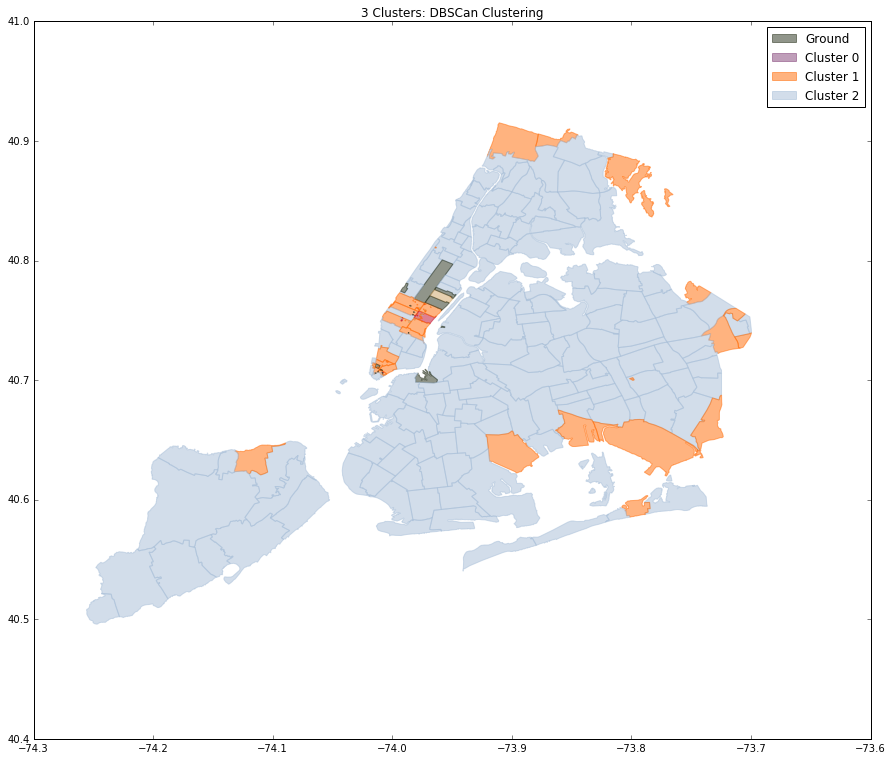

In [506]:
import matplotlib.pyplot as plt 
from descartes import PolygonPatch
fig = plt.figure(figsize=(15,15)) 
for i in nyc['features']:
    poly = i['geometry']
    postcode = str(i['properties']['postalCode'])
    ax = fig.gca()
    GREEN = kelly_colors_hex[19]
    if postcode in list(set(biz_zip)):
        color = kelly_colors_hex[int(mydata3[mydata3['zips']==postcode]['cluster'])+1]
        ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5, zorder=2 ))
    else:
        ax.add_patch(PolygonPatch(poly, fc=GREEN, ec=GREEN, alpha=0.5, zorder=2 ))
ax.axis('scaled')
import matplotlib.patches as mpatches

ground = mpatches.Patch(color=GREEN, alpha=0.5, label='Ground')
patch0 = mpatches.Patch(color=kelly_colors_hex[1], alpha=0.5, label='Cluster 0')
patch1 = mpatches.Patch(color=kelly_colors_hex[2], alpha=0.5, label='Cluster 1')
patch2 = mpatches.Patch(color=kelly_colors_hex[3], alpha=0.5, label='Cluster 2')
plt.legend(handles=[ground,patch0,patch1,patch2],loc='best')
plt.title('3 Clusters: DBSCan Clustering')

In [432]:
assignments={}
#assign data points to clusters
for ind,i in enumerate(x):
    min_dist=float('inf')
    closest_clust=None
    for c_ind,j in enumerate(centroids):
        if euclid_dist(i,j)<min_dist:
            min_dist = euclid_dist(i,j)
            closest_clust=c_ind
    if closest_clust in assignments:
        assignments[closest_clust].append(ind)
    else:
        assignments[closest_clust]=[ind]

In [433]:
zips = pd.Series(result.index,dtype=str)
cluster = pd.Series(0)
for i,key in assignments.iteritems():
    for j in key:
        cluster[j] = i
mydata2 = pd.DataFrame({'zips':biz_zip,
                       'cluster':cluster})

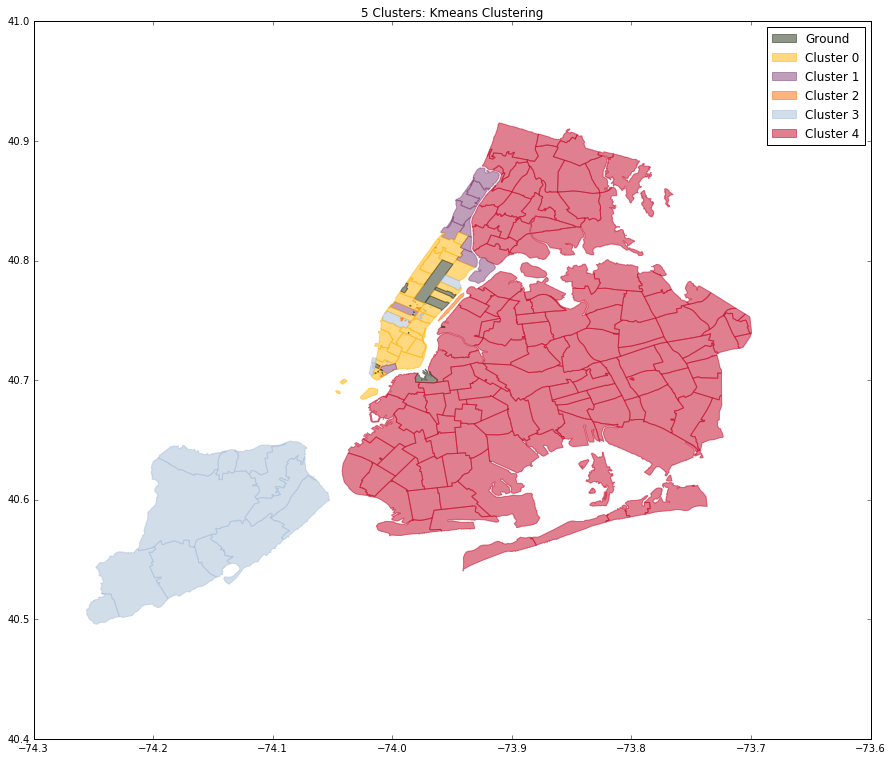

In [505]:
import matplotlib.pyplot as plt 
from descartes import PolygonPatch
fig = plt.figure(figsize=(15,15)) 
for i in nyc['features']:
    poly = i['geometry']
    postcode = str(i['properties']['postalCode'])
    ax = fig.gca()
    GREEN = kelly_colors_hex[19]
    if postcode in list(set(biz_zip)):
        color = kelly_colors_hex[int(mydata2[mydata2['zips']==postcode]['cluster'])]
        ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5, zorder=2 ))
    else:
        ax.add_patch(PolygonPatch(poly, fc=GREEN, ec=GREEN, alpha=0.5, zorder=2 ))
ax.axis('scaled')
import matplotlib.patches as mpatches

ground = mpatches.Patch(color=GREEN, alpha=0.5, label='Ground')
patch0 = mpatches.Patch(color=kelly_colors_hex[0], alpha=0.5, label='Cluster 0')
patch1 = mpatches.Patch(color=kelly_colors_hex[1], alpha=0.5, label='Cluster 1')
patch2 = mpatches.Patch(color=kelly_colors_hex[2], alpha=0.5, label='Cluster 2')
patch3 = mpatches.Patch(color=kelly_colors_hex[3], alpha=0.5, label='Cluster 3')
patch4 = mpatches.Patch(color=kelly_colors_hex[4], alpha=0.5, label='Cluster 4')
plt.legend(handles=[ground,patch0,patch1,patch2,patch3,patch4],loc='best')
plt.title('5 Clusters: Kmeans Clustering')

# 6. Model Comparison 

1
2
3
4
5
6
7
8
9
10


<function matplotlib.pyplot.show>

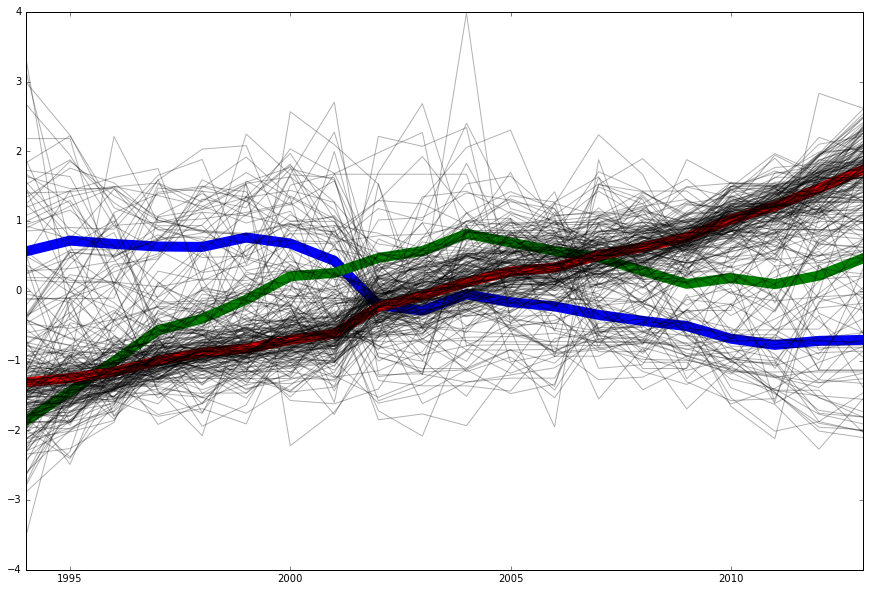

In [507]:
centroids=k_means_clust(x,3,10)
plt.figure(figsize=(15,10))
plt.xlim(1994,2013)
for i in range(len(centroids)):
    plt.plot(tr0,centroids[i],linewidth=10) 
for i in range(len(result)):
    plt.plot(result.iloc[i],'k',alpha=0.3)

plt.show

In [509]:
assignments={}
#assign data points to clusters
for ind,i in enumerate(x):
    min_dist=float('inf')
    closest_clust=None
    for c_ind,j in enumerate(centroids):
        if euclid_dist(i,j)<min_dist:
            min_dist = euclid_dist(i,j)
            closest_clust=c_ind
    if closest_clust in assignments:
        assignments[closest_clust].append(ind)
    else:
        assignments[closest_clust]=[ind]

In [510]:
zips = pd.Series(result.index,dtype=str)
cluster = pd.Series(0)
for i,key in assignments.iteritems():
    for j in key:
        cluster[j] = i
mydata4 = pd.DataFrame({'zips':biz_zip,
                       'cluster':cluster})

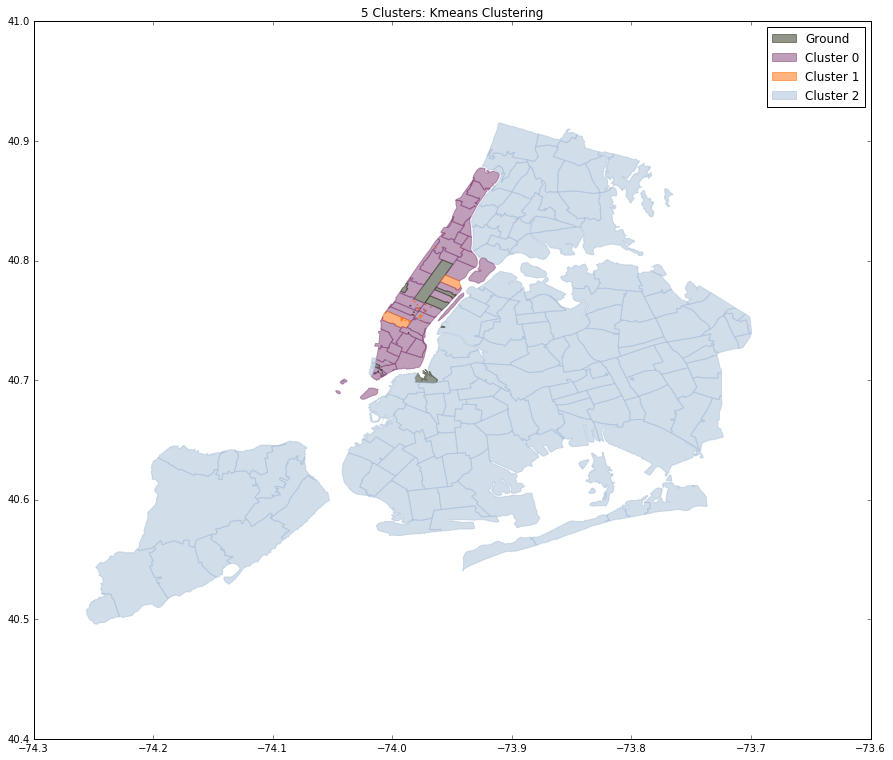

In [513]:
import matplotlib.pyplot as plt 
from descartes import PolygonPatch
fig = plt.figure(figsize=(15,15)) 
for i in nyc['features']:
    poly = i['geometry']
    postcode = str(i['properties']['postalCode'])
    ax = fig.gca()
    GREEN = kelly_colors_hex[19]
    if postcode in list(set(biz_zip)):
        color = kelly_colors_hex[int(mydata4[mydata4['zips']==postcode]['cluster'])+1]
        ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5, zorder=2 ))
    else:
        ax.add_patch(PolygonPatch(poly, fc=GREEN, ec=GREEN, alpha=0.5, zorder=2 ))
ax.axis('scaled')
import matplotlib.patches as mpatches

ground = mpatches.Patch(color=GREEN, alpha=0.5, label='Ground')
patch0 = mpatches.Patch(color=kelly_colors_hex[1], alpha=0.5, label='Cluster 0')
patch1 = mpatches.Patch(color=kelly_colors_hex[2], alpha=0.5, label='Cluster 1')
patch2 = mpatches.Patch(color=kelly_colors_hex[3], alpha=0.5, label='Cluster 2')
plt.legend(handles=[ground,patch0,patch1,patch2],loc='best')
plt.title('5 Clusters: Kmeans Clustering')

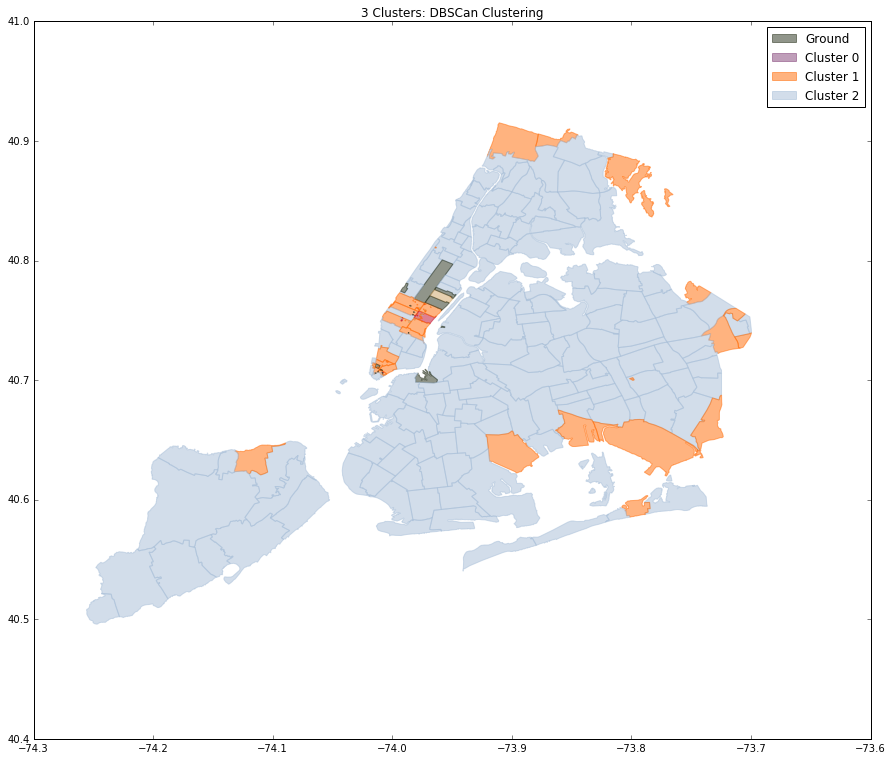

In [512]:
import matplotlib.pyplot as plt 
from descartes import PolygonPatch
fig = plt.figure(figsize=(15,15)) 
for i in nyc['features']:
    poly = i['geometry']
    postcode = str(i['properties']['postalCode'])
    ax = fig.gca()
    GREEN = kelly_colors_hex[19]
    if postcode in list(set(biz_zip)):
        color = kelly_colors_hex[int(mydata3[mydata3['zips']==postcode]['cluster'])+1]
        ax.add_patch(PolygonPatch(poly, fc=color, ec=color, alpha=0.5, zorder=2 ))
    else:
        ax.add_patch(PolygonPatch(poly, fc=GREEN, ec=GREEN, alpha=0.5, zorder=2 ))
ax.axis('scaled')
import matplotlib.patches as mpatches

ground = mpatches.Patch(color=GREEN, alpha=0.5, label='Ground')
patch0 = mpatches.Patch(color=kelly_colors_hex[1], alpha=0.5, label='Cluster 0')
patch1 = mpatches.Patch(color=kelly_colors_hex[2], alpha=0.5, label='Cluster 1')
patch2 = mpatches.Patch(color=kelly_colors_hex[3], alpha=0.5, label='Cluster 2')
plt.legend(handles=[ground,patch0,patch1,patch2],loc='best')
plt.title('3 Clusters: DBSCan Clustering')

In the overlay of K-means clustering, it's pretty clear that Staten Island, Brooklyn and most part of Queens are clustered as the same. Places with Manhattan, including upper west side, are another cluster.

But from the result of the DBScan clustering, I cannot clearly understand the centroids. The yellow areas include Hudson Yard, JFK airport, West New Brighton, and Tribaca and Financial District in lower Mahattan.